<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, my principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project I will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once I have collected and cleaned the data, I will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

I will use all the skills you have learned so far to build a predictive model.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

In [5]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [6]:
import requests
import bs4
from bs4 import BeautifulSoup
import pprint
from time import sleep
import pandas as pd
import numpy as np

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

In [7]:
request = requests.get(URL)
soup = BeautifulSoup(request.text, 'html.parser')
print(soup.prettify())
search = soup.find_all('div', class_="result")


<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script id="polyfill-script-bundle">
   /* Disable minification (remove `.min` from URL path) for more info */

(function(self, undefined) {function ArrayCreate(r){if(1/r==-Infinity&&(r=0),r>Math.pow(2,32)-1)throw new RangeError("Invalid array length");var n=[];return n.length=r,n}function Call(t,l){var n=arguments.length>2?arguments[2]:[];if(!1===IsCallable(t))throw new TypeError(Object.prototype.toString.call(t)+"is not a function.");return t.apply(l,n)}function Get(n,t){return n[t]}function HasOwnProperty(r,t){return Object.prototype.hasOwnProperty.call(r,t)}function HasProperty(n,r){return r in n}function IsArray(r){return"[object Array]"===Object.prototype.toString.call(r)}function IsCallable(n){return"function"==typeof n}function RequireObjectCoercible(e){if(null===e||e===undefined)throw TypeError();return e}function SameValueNonNumber(e,n){return e===n}funct

### Write 4 functions to extract each item: location, company, job, and salary.

In [8]:
## 
def extract_location(soup):
    try:
        return soup.find("span", attrs={'class':'location'}).text.strip()
    except:
        return None
    
    
extract_location(soup)        

In [ ]:
def extract_company(soup):
    try:
        return soup.find("span", attrs={'class':'company'}).text.strip()
    except:
        return None

    
extract_company(soup)    

In [ ]:
def extract_salary(soup):
    try:
        return soup.find("span", attrs={'class':'salaryText'}).text.strip()
    except:
            return None
    

extract_salary(soup)

In [ ]:
def extract_jobtitle(soup):
    try:
        return soup.find(class_='jobtitle', attrs={'data-tn-element':'jobTitle'}).text.strip()
    except:
        return None
    
extract_jobtitle(soup)

In [ ]:
def extract_summary_from_result(soup): 
    summaries = []
    try:
        spans = soup.find_all('div', attrs={'class': 'summary'})
        for span in spans:
            summaries = span.text.strip()
        return summaries 
    except:
        return None

extract_summary_from_result(soup)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary from U.S. Dollars to GBP to match the other cities if the currency is different.

In [ ]:
YOUR_CITY = 'London'

In [ ]:
from tqdm import tqdm 
# used tqdm but for me it was better to track the proccess of webscparing when I see the printed pages rather than
# total reslt of each city.

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 500 
results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'San+Diego', 'Las+Vegas', 
    'Washington', 'New+Jersey', 'Houston', 'Miami', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        print(city+" pg"+str(start/10.))
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.text, 'html.parser')
        for result in soup.find_all('div', class_="result"):
            results.append(result)
        sleep(10)
        

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Below I performed lots of webscrapping but because of many blocks and captcha solving pages, I devided webcrapping on smaller parts of min 500 to maximim of approximately 4000 per websraping, to gather all data from all cities I wanted.  I gathered first data for data scientists jobs in United States , then same from UK cities. After combining the data and removing null values for salary column, I needed to add extra websrapping to get more results for the final dataframe with Salaries values, so I webscpaped some machine learning jobs across UK. 

In [ ]:
import time 

url_template = "https://www.indeed.co.uk/jobs?q=data+science&l={}&start={}"
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.


results = []
# city = 'San+Francisco'
# for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle',
#     'Los+Angeles', 'Philadelphia', 'Atlanta', 'San+Diego', 'Boston' 
#     'Washington', 'New+Jersey', 'Houston', 'Miami', YOUR_CITY]): 
for city in set(['Nottingham', 'Birmingham','Manchester','Leeds','Reading','Cardiff','Glasgow','Edinburgh','Newcastle',\
             'Liverpool','Bristol','Sheffield','York','Oxford','Cambridge']):
    for start in range(0, max_results_per_city, 10):
        print(city+" pg"+str(start/10.))
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.text, 'html.parser')
        if soup.find('title').text == 'hCaptcha solve page':
            print(soup.find('title').text)
            break
        for result in soup.find_all('div', class_="result"):
            results.append(result)
        time.sleep(10)

In [ ]:
url_template = "https://uk.indeed.com/jobs?q=machine+learning&l={}&start={}"
max_results_per_city = 2000

results = []
city = 'London'

for start in range(0, max_results_per_city, 10):
    print(city+" pg"+str(start/10.))
    r = requests.get(url_template.format(city, start))
    soup = BeautifulSoup(r.text, 'html.parser')
    if soup.find('title').text == 'hCaptcha solve page':
        print(soup.find('title').text)
        break
    for result in soup.find_all('div', class_="result"):
        results.append(result)
    time.sleep(25)

In [ ]:
url_template = "https://uk.indeed.com/jobs?q=machine+learning&l={}&start={}"
max_results_per_city = 250

results = []
for city in set(['Birmingham','Cambridge', 'Manchester', 'Bristol', 'Edinburgh']):
    for start in range(0, max_results_per_city, 10):
        print(city+" pg"+str(start/10.))
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.text, 'html.parser')
        if soup.find('title').text == 'hCaptcha solve page':
            print(soup.find('title').text)
            break
        for result in soup.find_all('div', class_="result"):
            results.append(result)
        time.sleep(15)

In [ ]:
dictionary1 = [{'job_title': extract_jobtitle(result), 'company':extract_company(result), 'location': extract_location(result),
       'salary': extract_salary(result), 'summary': extract_summary_from_result(result)} for result in results]


df8 = pd.DataFrame(dictionary1)

In [1609]:
df8

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,"£32,000 a year",Honestly couldn't recommend the MLE stream eno...
1,Professor of Artificial Intelligence and Machi...,University of East London,London,"£59,828 a year","To succeed, you’ll need a PhD in Computer Scie..."
2,Data Scientist - Machine Learning,Cabot Financial,London,"£50,000 - £57,000 a year",Appreciate that success of developing a machin...
3,Machine Learning Operations (MLOPs) - Inside IR35,Harnham,London,£600 - £700 a day,As a ML Ops Engineer you will help to develop ...
4,Digital Fellow,Barts Health NHS Trust,London E1 8PR,"£43,712 - £49,325 a year",Capital Enterprise will work alongside Barts L...
...,...,...,...,...,...
1314,Business Development Representative,Increasingly,London,"£23,000 - £30,000 a year",We help ecommerce retailers drive basket reven...
1315,Lead Machine Learning Trainer,Harnham,London,"£85,000 - £100,000 a year",Proven commercial experience as a Data Scienti...
1316,Junior Software Developer / Full Stack Engineer,Client Server,London,"£30,000 - £40,000 a year",You could be joining a scale-up technology con...
1343,Data Scientist,Marshall Wolfe,London,"£70,000 - £90,000 a year",Experience developing and implementing state o...


In [1610]:
# dropping null values for the salary column
df8.dropna(subset=['salary'], inplace=True)

In [1611]:
# filtering null values of the location column to remove all duplicates 
df8[df8.location.isnull()].drop_duplicates()

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,"£32,000 a year",Honestly couldn't recommend the MLE stream eno...
47,Econometric Analyst - Machine Learning,Metrica Recruitment,None,"£28,000 - £35,000 a year",Their specialism lies in developing insights i...
64,Data Engineering Graduate Programme,Kubrick Group,None,"£32,000 - £40,000 a year",Embark on your exciting and challenging 15-wee...
67,Senior Machine Learning Engineer,Roke Manor Research,None,"£40,000 - £70,000 a year",Experience with a variety of different machine...
68,Client Engagement Manager,Observe Technologies,None,£9 - £15 an hour,Coordinate and handle multiple clients and acc...
124,DevOps Engineer,FLOX Ltd,None,"£30,000 a year",You will be responsible for our IT operations ...
126,Data Architect,ELEXON LIMITED,None,"£80,000 - £110,000 a year",Ability to realize different business capabili...
127,FinTech Lead Data Scientist,Metrica Recruitment,None,"£65,000 - £75,000 a year","Working within financial crime operations, you..."
208,Business Analyst,Kairos Recruitment Group,None,"£40,000 - £55,000 a year","£40,000 to £55,000 basic salary + package.\nEx..."
246,Data Architect,TribePost,None,"£50,000 - £70,000 a year",You are a hands Data Architect who is experien...


In [1623]:
# reset index for drop in next steps
df8.reset_index(inplace=True)
df8.drop(['index'], axis = 1, inplace=True)

In [1629]:
# make a list what I want to keep from null values of location column to get rid of duplicates
d = df8[df8.location.isnull()].drop_duplicates()
keep = list(d.index)
len(keep)

In [1628]:
# total number of null values in location column in this dataframe 
c = df8[df8.location.isnull()]
ind = c.index
nul = list(ind)
len(nul)

In [1630]:
# how many of them i want to drop, leaving only unique values 
to_drop = [x for x in nul if x not in keep]
len(to_drop)

In [1627]:
# final shape of one of the df after removing duplicates and null values, except locations unique null values.
df8.drop(df8.index[to_drop], inplace=True)
df8.shape

(480, 5)

In [1617]:
df8.head()

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,"£32,000 a year",Honestly couldn't recommend the MLE stream eno...
1,Professor of Artificial Intelligence and Machi...,University of East London,London,"£59,828 a year","To succeed, you’ll need a PhD in Computer Scie..."
2,Data Scientist - Machine Learning,Cabot Financial,London,"£50,000 - £57,000 a year",Appreciate that success of developing a machin...
3,Machine Learning Operations (MLOPs) - Inside IR35,Harnham,London,£600 - £700 a day,As a ML Ops Engineer you will help to develop ...
4,Digital Fellow,Barts Health NHS Trust,London E1 8PR,"£43,712 - £49,325 a year",Capital Enterprise will work alongside Barts L...


In [1631]:
# perfomimg same steps for df11(new df with different cities) as in df8
df11.dropna(subset=['salary'], inplace=True)

In [1632]:
# df11

In [1633]:
# df11.isnull().sum()

In [1634]:
df11[df11.location.isnull()].drop_duplicates()

,job_title,company,location,salary,summary
0,Senior Machine Learning Engineer,Roke Manor Research,None,"£40,000 - £70,000 a year",Experience with a variety of different machine...
38,Front End Engineer,SeeQuestor,None,"£40,000 - £80,000 a year",Experience with and/or interest in topics like...
47,Full Stack Developer,SeeQuestor,None,"£40,000 - £70,000 a year",Experience with and/or interest in topics like...
55,Full-Stack Developer,Michael Page UK,None,"£40,000 - £45,000 a year",You will also work closely with our Data Analy...
56,Senior Data Scientist,Metrica Recruitment,None,"£70,000 - £80,000 a year",At least three years' experience in developing...
90,Software Engineer,Muir Matheson Aviation Limited,None,"£30,000 - £50,000 a year",Our company designs advanced systems and softw...
125,Capability Lead - Autonomous Systems & Human-M...,Rowden Technologies,None,"£60,000 - £70,000 a year",The sub-Capability Lead will support an increa...
127,Junior Analytics Consultant,Snap Analytics,None,"£25,000 - £30,000 a year",Data science and machine learning.\nSnap Analy...
159,Senior Data Scientist - Statistical Modeller,Lowellgroup,None,"£45,000 - £62,000 a year",You'll deliver high-quality statistical and ma...
181,Defence Data Scientist,Metrica Recruitment,None,"£40,000 - £45,000 a year","The content of decision aids, used for strateg..."


In [1635]:
df11.reset_index(inplace=True)
df11.drop(['index'], axis = 1, inplace=True)

In [1639]:
d = df11[df11.location.isnull()].drop_duplicates()
keep = list(d.index)
len(keep)

In [1640]:
c = df11[df11.location.isnull()]
ind = c.index
nul = list(ind)
len(nul)

In [1641]:
to_drop = [x for x in nul if x not in keep]
len(to_drop)

In [1642]:
df11.drop(df11.index[to_drop], inplace=True)
df11.shape

(515, 5)

In [1643]:
df11.head()

,job_title,company,location,salary,summary
0,Senior Machine Learning Engineer,Roke Manor Research,None,"£40,000 - £70,000 a year",Experience with a variety of different machine...
1,Junior Data Scientist,Salford Royal NHS Foundation Trust,Salford M50,"£21,892 - £24,157 a year",The successful candidate will be working on a ...
2,Junior Data Scientist,Northern Care Alliance NHS Group,Salford,"£21,892 - £24,157 a year",The successful candidate will be working on a ...
3,Machine Learning Engineer,N Brown,Manchester,"£55,000 a year","Lead technically across Data Science projects,..."
4,"Software Degree Apprenticeship level 4, 5 and 6",QA Apprenticeships,Manchester,£423 a week,Our apprenticeship program is crafted to meet ...


Below I gather mini dataftames that I will concatenate later

In [ ]:
# df4

In [ ]:
# df5 

In [ ]:
# df6

In [ ]:
# df7

In [ ]:
# df8

In [ ]:
# df9

In [ ]:
# df3

In [ ]:
# df1 

In [ ]:
# df2

In [ ]:
# df0

In [1644]:
frames = [df0, df1, df2, df3, df4, df5, df6, df7, df9, df10]

scrapped_df = pd.concat(frames)
scrapped_df

,job_title,company,location,salary,summary
0,Data Scientist,choozle.com,"Denver, CO",None,Department Engineering Employment Type Full Ti...
1,Data Scientist,Wunderman Thompson,"Denver, CO","$130,000 - $150,000 a year",You'll be part of the Data Science Innovation ...
2,Data Scientist,"VIZIO, Inc.","Denver, CO 80014",None,Dig deep into high volumes of data to find ano...
3,Climate Data Scientist,McKinsey & Company,"Denver, CO 80202 (Union Station area)",None,"McKinsey’s Climate Analytics team is a small, ..."
4,Senior Data Scientist,Uplight,"Boulder, CO 80301","$115,000 - $135,000 a year",Experience with data pipelines and workflows.\...
...,...,...,...,...,...
696,SENIOR BIOINFORMATICIAN,Mogrify Ltd,Cambridge,None,Analyze and interpret experimental data from m...
697,Senior Bioinformatician,Cpl Life Sciences,Cambridge,None,Experience with and understanding of tools use...
698,Statistical Leader - Research (Non-Clinical),GSK,Stevenage SG1,None,"We design experiments, analyze data, and visua..."
699,Senior Computational Systems Biologist (Bioinf...,Healx,Cambridge,None,An expert in the analysis of -omics data from ...


In [1645]:
# we can see a lot of null values in salary column that we have to remove
scrapped_df.isnull().sum()

job_title        0
company          0
location       335
salary       11460
summary          0
dtype: int64

In [1646]:
scrapped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12527 entries, 0 to 700
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_title  12527 non-null  object
 1   company    12527 non-null  object
 2   location   12192 non-null  object
 3   salary     1067 non-null   object
 4   summary    12527 non-null  object
dtypes: object(5)
memory usage: 587.2+ KB


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [ ]:
## YOUR CODE HERE

In [1647]:
# drop null values in salary column
scrapped_df.dropna(subset=['salary'], inplace=True)

In [1648]:
scrapped_df.shape

(1067, 5)

In [1649]:
scrapped_df.reset_index(inplace=True)

In [1651]:
scrapped_df.drop(['index'], axis = 1, inplace=True)

In [1652]:
# null location values that I want to keep 
d = scrapped_df[scrapped_df.location.isnull()].drop_duplicates()
keep = list(d.index)
len(keep)

28

In [1653]:
# TOTAL NULL VALUES OF LOCATIONS
c = scrapped_df[scrapped_df.location.isnull()]
ind = c.index
nul = list(ind)
len(nul)

111

In [1654]:
# how many to drop and keep uniques
to_drop = [x for x in nul if x not in keep]
len(to_drop)
# to_drop

83

In [1655]:
scrapped_df.drop(scrapped_df.index[to_drop], inplace=True)

In [1656]:
# final shape of scrapped data . Need to add more values
scrapped_df.shape

(984, 5)

In [1657]:
# adding machine learning values and combaning with previous cleaned dataframe (scrapped_df)
dfs = [df8, df11, scrapped_df] 

# reset index and drop old index column
indeed = pd.concat(dfs).reset_index()
indeed.drop('index', axis=1, inplace=True)

In [1658]:
indeed

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,"£32,000 a year",Honestly couldn't recommend the MLE stream eno...
1,Professor of Artificial Intelligence and Machi...,University of East London,London,"£59,828 a year","To succeed, you’ll need a PhD in Computer Scie..."
2,Data Scientist - Machine Learning,Cabot Financial,London,"£50,000 - £57,000 a year",Appreciate that success of developing a machin...
3,Machine Learning Operations (MLOPs) - Inside IR35,Harnham,London,£600 - £700 a day,As a ML Ops Engineer you will help to develop ...
4,Digital Fellow,Barts Health NHS Trust,London E1 8PR,"£43,712 - £49,325 a year",Capital Enterprise will work alongside Barts L...
...,...,...,...,...,...
1974,Apprentice Bioinformatician,Alchemab Therapeutics Ltd,Babraham CB22 3AT,"£19,000 a year",Keeping our data clean and up to date by helpi...
1975,"Lead Machine Learning Scientist - Healthcare, NLP",SoCode,Cambridge,"£60,000 - £80,000 a year",Implement ML pipelines using both structured a...
1976,Senior Bioinformatician,Wellcome Sanger Institute,Hinxton,"£37,865 - £45,359 a year",Demonstrated ability to independently run data...
1977,Principal Bioinformatician,Wellcome Sanger Institute,Hinxton,"£45,516 - £54,524 a year",A computer science related professional qualif...


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [1659]:
# preview of the data with Dollars values 

indeed[indeed["salary"].str.contains('£')==False]

,job_title,company,location,salary,summary
995,Data Scientist,Wunderman Thompson,"Denver, CO","$130,000 - $150,000 a year",You'll be part of the Data Science Innovation ...
996,Senior Data Scientist,Uplight,"Boulder, CO 80301","$115,000 - $135,000 a year",Experience with data pipelines and workflows.\...
997,Data Scientist 3,Oracle,"Broomfield, CO 80021 (Interlocken area)","$99,333 - $178,795 a year",Ability to perform data analysis on aggregated...
998,Data Scientist,AirDNA,"Denver, CO","$100,000 - $125,000 a year",Assess the effectiveness and accuracy of new d...
999,Data Science Resident,Galvanize Inc.,"Denver, CO",$35 an hour,"As part of the Residency program, you will rec..."
...,...,...,...,...,...
1678,Data Quality Analyst,Employees Retirement System of Texas,"Austin, TX 78701 (Downtown area)","$6,667 - $7,917 a month",Leverages data management knowledge to define ...
1679,Data Quality Analyst,Employees Retirement System of Texas,"Austin, TX 78701 (Downtown area)","$6,667 - $7,917 a month",Leverages data management knowledge to define ...
1680,Machine Learning Research Scientist,Senseye,"Austin, TX","$100,000 - $120,000 a year",The Machine learning team at Senseye exists to...
1681,SENIOR DEEP LEARNING SOFTWARE ENGINEER,Harnham,None,"$170,000 - $200,000 a year",Work in collaboration with data engineers and ...


In [1660]:
# convert USD to GBP , taking salary string, convert it to a number, averaging a salary if its a range
import re


salaries = []
for row in indeed.salary:
    if '£' not in row:
        row = re.sub(r"[a-zA-Z$, ]","", row)
        row = row.split('-')
        row= [float(i)*0.72 for i in row]
        if len(row) > 1:
            row = round(sum(row)/2, 0)
        else:
            row = round(sum(row), 0)
    else:
        row = re.sub(r"[a-zA-Z£, ]","", row)
        row = row.split('-')
        row= [float(i) for i in row]
        if len(row) > 1:
            row = round(sum(row)/2, 0)
        else:
            row = round(sum(row), 0)
    salaries.append(row)
print(salaries)
 
# assign salary column to float values   
indeed.salary = salaries

[32000.0, 59828.0, 53500.0, 650.0, 46518.0, 48586.0, 650.0, 53500.0, 48586.0, 37500.0, 46518.0, 85000.0, 31166.0, 30000.0, 75000.0, 38304.0, 32000.0, 47722.0, 37500.0, 30000.0, 50000.0, 45000.0, 180000.0, 725.0, 36814.0, 525.0, 50000.0, 30000.0, 37500.0, 71924.0, 36814.0, 27000.0, 32000.0, 180000.0, 60000.0, 525.0, 725.0, 325.0, 80000.0, 1273.0, 85000.0, 37500.0, 50000.0, 60000.0, 650.0, 31166.0, 60000.0, 31500.0, 650.0, 31166.0, 36814.0, 37500.0, 45000.0, 70000.0, 36500.0, 1273.0, 75000.0, 57500.0, 32500.0, 36500.0, 48710.0, 700.0, 40000.0, 36000.0, 32000.0, 37500.0, 55000.0, 12.0, 57500.0, 42724.0, 45000.0, 67000.0, 30000.0, 42794.0, 100000.0, 65000.0, 95000.0, 42794.0, 85000.0, 57500.0, 45000.0, 32500.0, 40000.0, 47722.0, 30000.0, 92500.0, 475.0, 37500.0, 75000.0, 55000.0, 37500.0, 75000.0, 55000.0, 475.0, 80000.0, 65000.0, 51500.0, 600.0, 42192.0, 42192.0, 95000.0, 112500.0, 32438.0, 37500.0, 700.0, 65000.0, 95000.0, 40000.0, 47000.0, 77500.0, 57500.0, 950.0, 24000.0, 60000.0, 9000

In [1661]:
indeed.head(8)

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,32000.0,Honestly couldn't recommend the MLE stream eno...
1,Professor of Artificial Intelligence and Machi...,University of East London,London,59828.0,"To succeed, you’ll need a PhD in Computer Scie..."
2,Data Scientist - Machine Learning,Cabot Financial,London,53500.0,Appreciate that success of developing a machin...
3,Machine Learning Operations (MLOPs) - Inside IR35,Harnham,London,650.0,As a ML Ops Engineer you will help to develop ...
4,Digital Fellow,Barts Health NHS Trust,London E1 8PR,46518.0,Capital Enterprise will work alongside Barts L...
5,Data Scientist,Great Ormond Street Hospital NHS Foundation Trust,London,48586.0,As Data Scientist for the Clinical Informatics...
6,Machine Learning Operations (MLOPs) - Inside IR35,Harnham,London,650.0,As a ML Ops Engineer you will help to develop ...
7,Data Scientist - Machine Learning,Cabot Financial,London,53500.0,Appreciate that success of developing a machin...


In [1662]:
#  Filter salaries per hour, per day, weekly etc.
drop = indeed[indeed.salary <= 5000].index

In [1663]:
# drop those rows, reset index for final dataframe

indeed.drop(indeed.index[drop], inplace=True)

In [1664]:
indeed.reset_index(drop=True)

,job_title,company,location,salary,summary
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,None,32000.0,Honestly couldn't recommend the MLE stream eno...
1,Professor of Artificial Intelligence and Machi...,University of East London,London,59828.0,"To succeed, you’ll need a PhD in Computer Scie..."
2,Data Scientist - Machine Learning,Cabot Financial,London,53500.0,Appreciate that success of developing a machin...
3,Digital Fellow,Barts Health NHS Trust,London E1 8PR,46518.0,Capital Enterprise will work alongside Barts L...
4,Data Scientist,Great Ormond Street Hospital NHS Foundation Trust,London,48586.0,As Data Scientist for the Clinical Informatics...
...,...,...,...,...,...
1848,Apprentice Bioinformatician,Alchemab Therapeutics Ltd,Babraham CB22 3AT,19000.0,Keeping our data clean and up to date by helpi...
1849,"Lead Machine Learning Scientist - Healthcare, NLP",SoCode,Cambridge,70000.0,Implement ML pipelines using both structured a...
1850,Senior Bioinformatician,Wellcome Sanger Institute,Hinxton,41612.0,Demonstrated ability to independently run data...
1851,Principal Bioinformatician,Wellcome Sanger Institute,Hinxton,50020.0,A computer science related professional qualif...


### Save your results as a CSV

In [ ]:
## YOUR CODE HERE
indeed.to_csv('scrapped_indeed.csv')

### Load in the the data of scraped salaries

In [1665]:
## YOUR CODE HERE
indeed = pd.read_csv('scrapped_indeed.csv')
indeed.shape

(1853, 6)

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [1666]:
## YOUR CODE HERE
median = np.median(indeed.salary)
print('Median salary is £{} '.format(median))

Median salary is £55000.0 


In [1669]:
# create new binary variable that if it is true when the salary is high

indeed['high'] = [1 if x >= median else 0 for x in indeed.salary]
# indeed['low'] = [1 if x < median else 0 for x in indeed.salary]

In [1923]:
# percentiles of salary values

indeed.salary.quantile([0.1, 0.25, 0.5, 0.75, 0.85, 0.90, 0.95, 0.97, 1])

0.10     32000.0
0.25     41584.0
0.50     55000.0
0.75     75000.0
0.85     82584.0
0.90     92500.0
0.95    115200.0
0.97    130000.0
1.00    252000.0
Name: salary, dtype: float64

In [1671]:
# Create new column only for States values across USA

states = []

for loc in indeed.location:
    items = str(loc).split(',')
    if len(items) == 1:
        states.append(None)
    elif len(items) == 2:
        items = items[1].split(' ')
        states.append(items[1])
        


indeed['state'] = states
indeed.drop('Unnamed: 0',axis=1, inplace=True)

In [1672]:
# Create new column of just city names

cities = []

for city in indeed.location:
    items = str(city).split(',')
    if len(items) == 1:
        for item in items:
            items = item.split(' ')[0].replace('South', 'London').replace('East', 'London').replace('University', 'Birmingham')
        cities.append(items)
    elif len(items) == 2:
        cities.append(items[0])

indeed['city'] = cities 
indeed.head(20)

,job_title,company,location,salary,summary,high,state,city
0,Machine Learning Engineer - Graduate Programme,Kubrick Group,NaN,32000.0,Honestly couldn't recommend the MLE stream eno...,0,None,nan
1,Professor of Artificial Intelligence and Machi...,University of East London,London,59828.0,"To succeed, you’ll need a PhD in Computer Scie...",1,None,London
2,Data Scientist - Machine Learning,Cabot Financial,London,53500.0,Appreciate that success of developing a machin...,0,None,London
3,Digital Fellow,Barts Health NHS Trust,London E1 8PR,46518.0,Capital Enterprise will work alongside Barts L...,0,None,London
4,Data Scientist,Great Ormond Street Hospital NHS Foundation Trust,London,48586.0,As Data Scientist for the Clinical Informatics...,0,None,London
5,Data Scientist - Machine Learning,Cabot Financial,London,53500.0,Appreciate that success of developing a machin...,0,None,London
6,Data Scientist,Great Ormond Street Hospital NHS Foundation Trust,London,48586.0,As Data Scientist for the Clinical Informatics...,0,None,London
7,Data Scientists,Datasource,London,37500.0,Data Analysis / Modelling (statistical modelli...,0,None,London
8,Digital Fellow,Barts Health NHS Trust,London E1 8PR,46518.0,Capital Enterprise will work alongside Barts L...,0,None,London
9,Number 10 Innovation Fellows,Government Digital Service,London,85000.0,Ministry of Defence: Serious games: using deep...,1,None,London


In [1673]:
# cities = [str(x).split(' ')[0].replace(',', '').replace('South', 'London').replace('University', 'Birmingham').replace('San', 'San Francisco').replace('New', 'New York').replace('Los', 'Los Angeles').replace('Long', 'Long Island City').replace('East', 'London').replace('Oak', 'Oak Brook') for x in indeed.location]

In [1674]:
indeed.city.value_counts()

London          682
Cambridge       130
Bristol         112
Oxford          102
nan              86
               ... 
Edison            1
Islington         1
New               1
Santa Monica      1
Bedford           1
Name: city, Length: 76, dtype: int64

In [1675]:
indeed = indeed[indeed.city != 'New']
indeed.reset_index(inplace=True, drop=True)

In [1676]:
# indeed.groupby(by="city").salary.mean().plot(kind="bar", figsize=(16, 12));

#### Thought experiment: What is the baseline accuracy for this model?

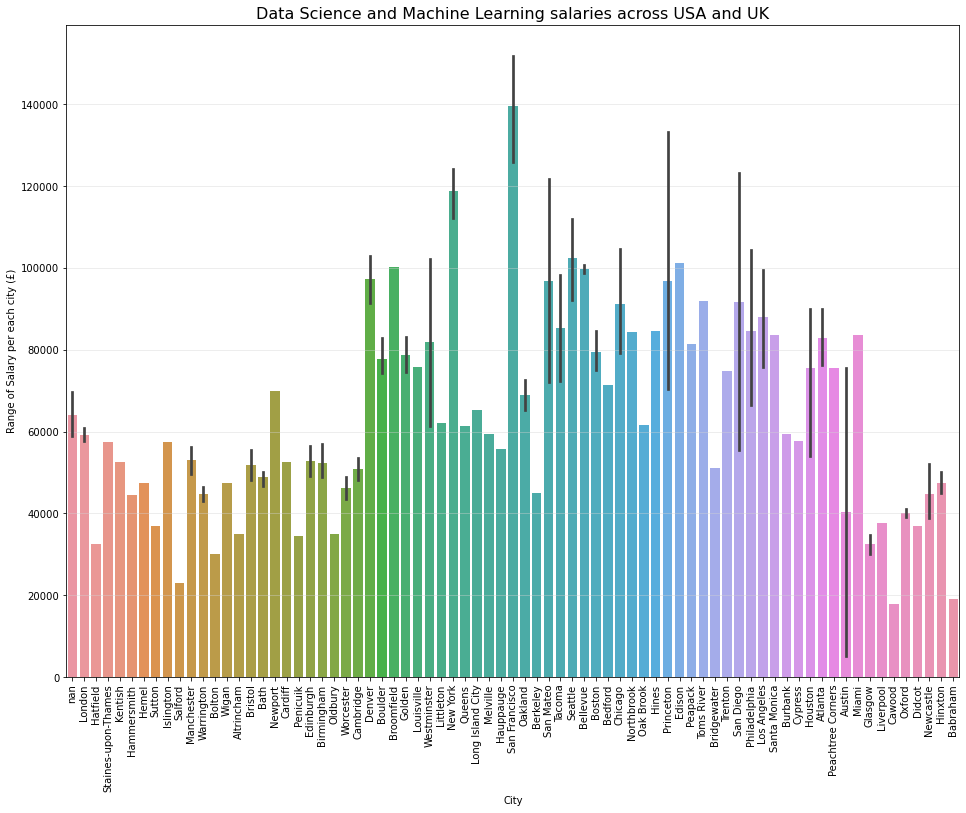

In [1677]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(16, 12))

sns.barplot(data = indeed, x='city', y ='salary')
plt.title('Data Science and Machine Learning salaries across USA and UK', fontsize=16)
ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

ax.set_xlabel('City')
ax.set_ylabel('Range of Salary per each city (£)')

ax.set_xticklabels(indeed.city.unique(), rotation =90);
plt.show()

In [1678]:
## YOUR CODE HERE

print("Baseline Accuracy:",indeed.high.value_counts().max()/sum(indeed.high.value_counts()))

Baseline Accuracy: 0.5178185745140389


In [1679]:
# indeed.high.value_counts()

/Users/Ketevana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='salary', ylabel='Density'>

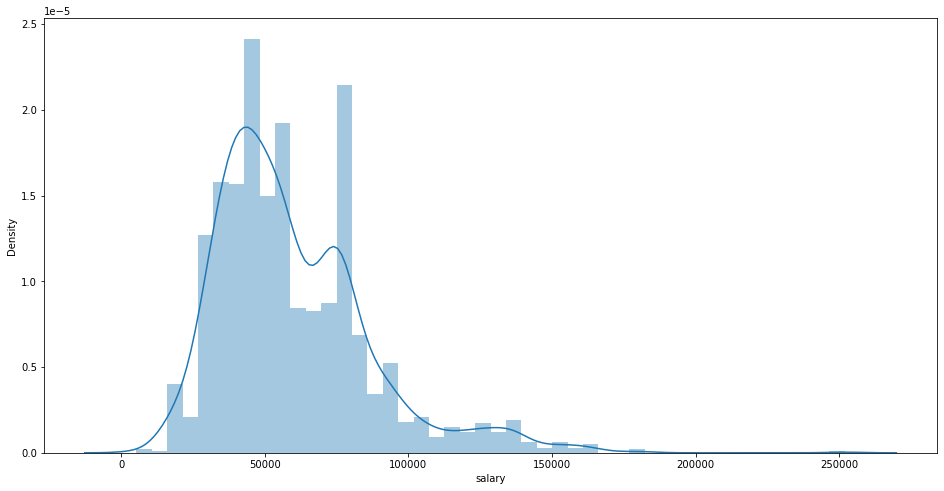

In [1918]:
# Plot salary range in pounds
fig, ax = plt.subplots(figsize=(16, 8))

sns.distplot(indeed["salary"], ax=ax)

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [ ]:
## YOUR CODE HERE
# from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score

In [1864]:
feature = ['city']

In [1865]:
X = indeed[feature]
y = indeed['high']

In [1866]:
# Scaling features
X = pd.get_dummies(X)

In [1867]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1296, 75), (556, 75), (1296,), (556,))

In [1868]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier


lr = LogisticRegression()

lr.fit(X_train, y_train)

print('Train score', lr.score(X_train, y_train))
print('Test score', lr.score(X_test, y_test))
print('Mean CV score', cross_val_score(lr, X_train, y_train, cv=5).mean())

Train score 0.7006172839506173
Test score 0.7212230215827338
Mean CV score 0.6805643005643006


In [1869]:
print('The coeficient of LR model is ', lr.coef_)
print('The intercept of LR model is ', lr.intercept_)

The coeficient of LR model is  [[-1.7123378   1.16185291 -0.39924867 -1.42778425 -1.7123378   0.35100861
   0.78100156 -0.75866584 -0.63208763 -0.45276581  1.75630887  2.08725479
  -0.45276581 -0.80799794  0.5955366   0.5955366  -0.36231902 -1.5343056
  -2.30315256  0.95814982  0.35100861  1.88038873 -2.03541295 -0.39270629
   0.         -2.08677906  0.78100156 -0.98350093 -0.45276581  0.
   0.          0.35100861 -1.5343056   0.5955366   0.35100861 -0.45276581
   0.5955366  -1.85769757  0.01752576  0.35100861  0.5955366   0.35100861
  -0.19889483  0.35100861  0.35100861  1.9572564  -0.76997413  1.6584748
   0.78100156  0.35100861  0.35100861  0.         -3.24243086  0.35100861
   0.5955366  -0.75866584  0.35100861  0.78100156  0.35100861 -0.45276581
   0.5955366   1.80091363  0.35100861  0.          1.49580022  0.78100156
  -0.45276581  0.78100156  0.35100861  1.05474003 -1.85769757  0.35100861
   0.         -0.29250765  0.08334207]]
The intercept of LR model is  [0.26393225]


In [1870]:
knn_params = {
    'n_neighbors': [3, 5, 9,10, 13, 14, 15, 16, 17, 20, 25, 30, 40, 50],                 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn1 = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn1,
                              knn_params,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   15.5s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 9, 10, 13, 14, 15, 16, 17, 20,
                                         25, 30, 40, 50],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

In [1871]:
best_knn = knn_gridsearch.best_estimator_

In [1872]:
print('Best Training score:', best_knn.score(X_train, y_train))
print('Best Test score:',best_knn.score(X_test, y_test))
print('Mean cv train score :', cross_val_score(best_knn, X_train, y_train, cv=6).mean(),'\n')

Best Training score: 0.7006172839506173
Best Test score: 0.7212230215827338
Mean cv train score : 0.6736111111111112 



In [1873]:
model_lg = LogisticRegression(max_iter=1000, solver='lbfgs')
model_lg.fit(X_train, y_train)

# list(model_lg.get_params().keys())
sc = cross_val_score(model_lg, X_train, y_train, cv=5).mean()
print('Training score:', model_lg.score(X_train, y_train))
print('Test score:',model_lg.score(X_test, y_test))
print('Mean cv training score :', sc)
print('Mean cv test score :', cross_val_score(model_lg, X_test, y_test, cv=5).mean(),'\n')

Training score: 0.7006172839506173
Test score: 0.7212230215827338
Mean cv training score : 0.6805643005643006
Mean cv test score : 0.701560489060489 



In [1874]:
coef_df = pd.DataFrame()
coef_df['Features'] = X_train.columns
coef_df['Coefficients'] = model_lg.coef_[0]
coef_df['Abs_coef'] = abs(model_lg.coef_[0])

coef_df.sort_values(by='Abs_coef',ascending=False).head(20)

,Features,Coefficients,Abs_coef
52,city_Oxford,-3.242431,3.242431
18,city_Cawood,-2.303153,2.303153
11,city_Boulder,2.087255,2.087255
25,city_Glasgow,-2.086779,2.086779
22,city_Didcot,-2.035413,2.035413
45,city_New York,1.957256,1.957256
21,city_Denver,1.880389,1.880389
70,city_Warrington,-1.857698,1.857698
37,city_Liverpool,-1.857698,1.857698
61,city_San Francisco,1.800914,1.800914


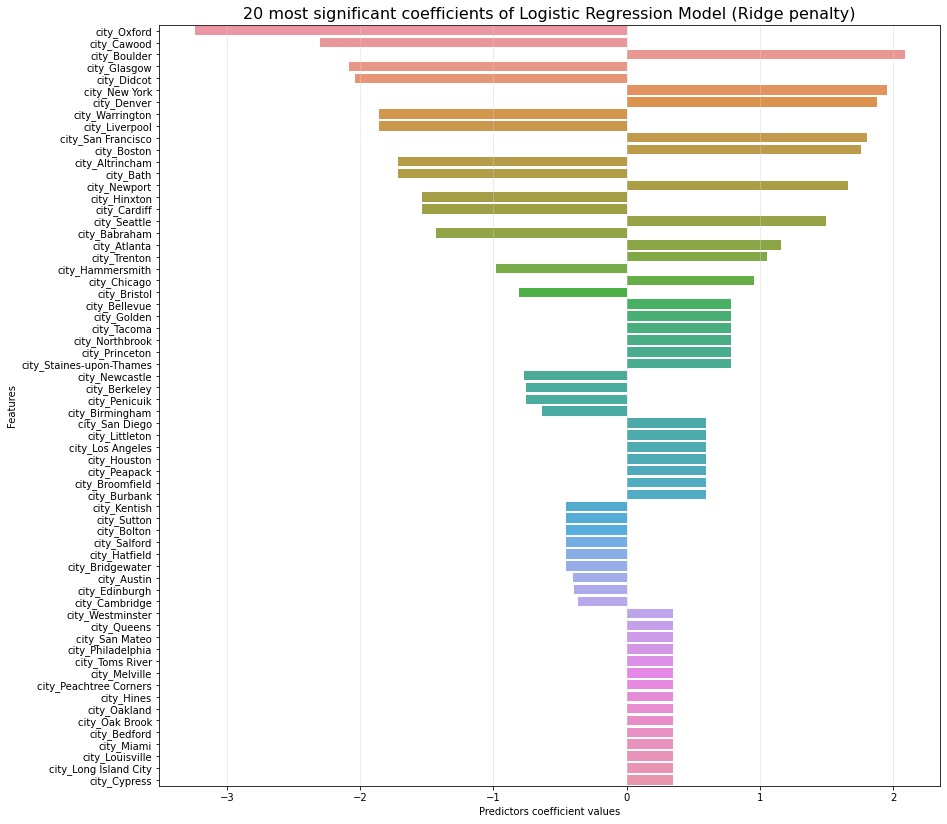

In [1875]:
fig,ax= plt.subplots(figsize=(14,14))

sns.barplot(data = coef_df.sort_values('Abs_coef', ascending=False).loc[:20], x='Coefficients', y ='Features')
plt.title('20 most significant coefficients of Logistic Regression Model (Ridge penalty)', fontsize=16)
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

ax.set_xlabel('Predictors coefficient values')
ax.set_ylabel('Features')
plt.show()

The graph above displays the significance of different features at predictiong the salary class, either it is high or
low. We can observe that Oxford is 3 standard deviations below the mean along with Glasgow and Cawood (2 standard deviations below the mean) which means they are the most impactful at predicting Low salary class. Denver, Boulder and New York cities has the highest impact at predicting High salary class. Some cities like Miami, Santa Monica, Westmister, Louisville, Cypress have low impact of prediciting High salary class, it might just be related to a little amount of data points of those cities.  

In [1876]:
# Adding new variables into Logistic Regression Model

In [1877]:
predictors = indeed.copy()

In [1878]:
predictors.drop(['company', 'location', 'salary', 'summary'], axis=1, inplace=True)

In [1879]:
y = predictors.pop('high')

x = pd.get_dummies(predictors)

In [1880]:
predictors

,job_title,state,city
0,Machine Learning Engineer - Graduate Programme,None,nan
1,Professor of Artificial Intelligence and Machi...,None,London
2,Data Scientist - Machine Learning,None,London
3,Digital Fellow,None,London
4,Data Scientist,None,London
...,...,...,...
1847,Apprentice Bioinformatician,None,Babraham
1848,"Lead Machine Learning Scientist - Healthcare, NLP",None,Cambridge
1849,Senior Bioinformatician,None,Hinxton
1850,Principal Bioinformatician,None,Hinxton


In [1881]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# stratify=y

((1296, 543), (556, 543), (1296,), (556,))

In [1882]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5).mean()
print('Training score:', model.score(X_train, y_train))
print('Test score:',model.score(X_test, y_test))
print('Mean CV training score :', scores)
print('Mean CV test score :', cross_val_score(model, X_test, y_test, cv=5).mean())

Training score: 0.9737654320987654
Test score: 0.9262589928057554
Mean CV training score : 0.9027710127710128
Mean CV test score : 0.879520592020592


In [1883]:
#  Applying Grid Search on Logistic Regression model

lg_params = {'penalty': ['elasticnet'],
             'l1_ratio':[0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.99, 1],
             'solver': ['saga'],
             'C': np.logspace(-5, 5, 5)}

In [1884]:
lr_gridsearch = GridSearchCV(model,
                             lg_params,
                             n_jobs=-2, 
                             cv=5, 
                             verbose=1)

lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  3.6min finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05]),
                         'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.99, 1],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             verbose=1)

In [1885]:
lr_gridsearch.best_params_

{'C': 1.0, 'l1_ratio': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'}

In [1892]:
lr_gridsearch.best_score_

0.9027710127710128

In [1893]:
best_Lr = lr_gridsearch.best_estimator_

In [1894]:
# Best Grid seach Score of Logistic regression model of the test set
best_Lr.score(X_test,y_test)

0.9262589928057554

In [1888]:
coefficient_df = pd.DataFrame()
coefficient_df['Features'] = X_train.columns
coefficient_df['Best_LR_Coefficients'] = best_Lr.coef_[0]
coefficient_df['Abs_coef'] = abs(best_Lr.coef_[0])

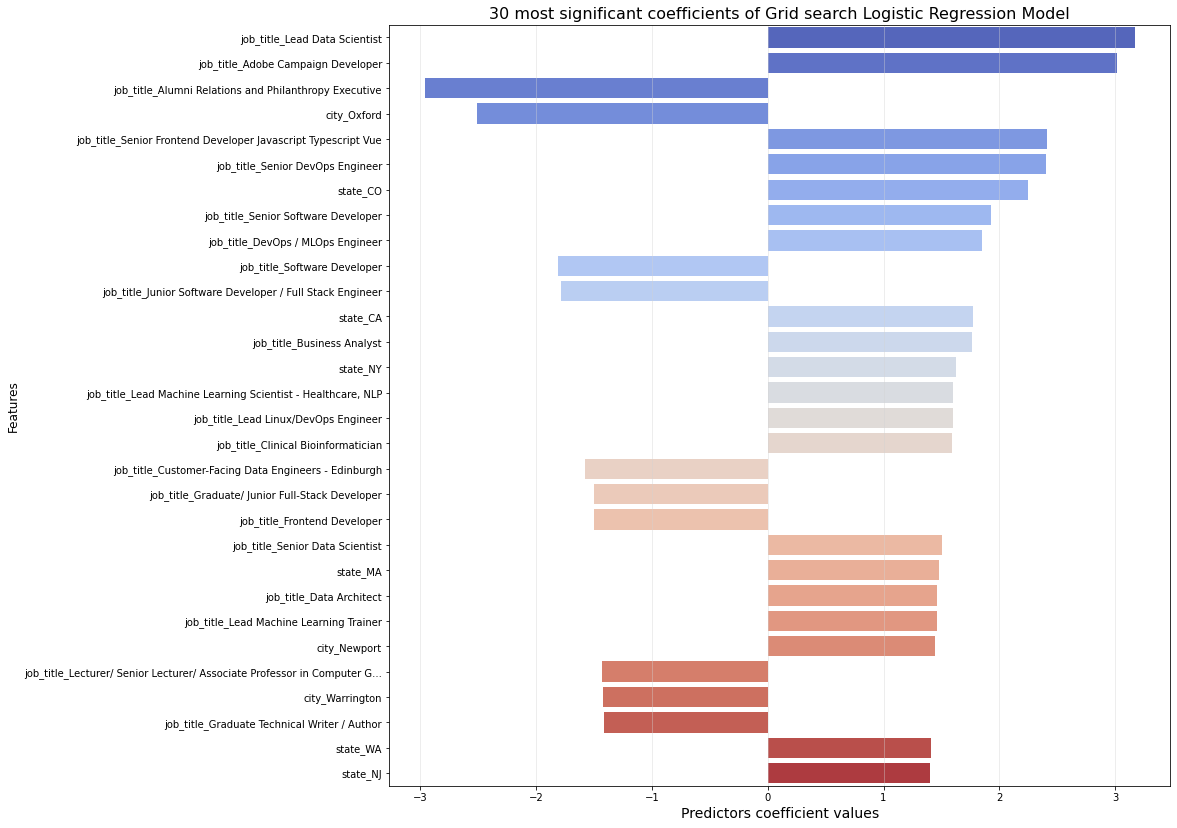

In [1889]:
fig,ax= plt.subplots(figsize=(14,14))

sns.barplot(data = coefficient_df.sort_values(by='Abs_coef',ascending=False).head(30), x='Best_LR_Coefficients', y ='Features', palette='coolwarm')
plt.title('30 most significant coefficients of Grid search Logistic Regression Model', fontsize=16)
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

ax.set_xlabel('Predictors coefficient values', fontsize=14)
ax.set_ylabel('Features', fontsize=12)
plt.show()

New variables definitely has value in predicticting salary class. It has improved our Mean CV training score of Logistic Regression model from 0.68 to 0.90 (same 0.90 score with Grid search) . Tuning the KNN and Logistic Regression models by testing parameter ranges, regularization strengths using the Grid Search helped to improve scores , the highest Mean Cv score on Test set got the LR model with 0.92 acrruracy score. Taking into account the baseline of 0.51 at predicting salary class, our models are doing really well.

At the graph above , we can see that the most paid jobs are at positions like Lead Data Scientist and Adobe campaign Developer in Colorado, California and New York states. Whereas Alumni Relations and Philanthropy Executive would have most low paid, which is reasonable because it can be related to charity and volunteering. Oxford and Warrington cities are the lowest paid cities across UK of DS and ML jobs.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [1903]:
## YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5)
cross_val_score(rfc,X_train,y_train,cv=5).mean()

0.8024710424710424

In [1566]:
# rfc.get_params()

In [1904]:
params = {'max_depth':range(4, 28),
          'max_features':["auto","log2",0.5],
         'criterion':['gini','entropy'],
         'bootstrap':[True,False],
         'n_estimators': range(100, 260, 40)
         }

rfgs = GridSearchCV(rfc, params, n_jobs=-2, verbose=1, cv=5, return_train_score=True)
rfgs.fit(X_train,y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-2)]: Done 2436 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-2)]: Done 3186 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-2)]: Done 4036 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-2)]: Done 4986 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-2)]: Done 5760 out of 5760 | elapsed: 23.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=5), n_jobs=-2,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 28),
                         'max_features': ['auto', 'log2', 0.5],
                         'n_estimators': range(100, 260, 40)},
             return_train_score=True, verbose=1)

In [1905]:
rfgs.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 27,
 'max_features': 'log2',
 'n_estimators': 180}

In [1906]:
# Mean CV score on Train data
rfgs.best_score_  

0.9043243243243243

In [1907]:
best_rfgs = rfgs.best_estimator_

In [1908]:
rfgs_coef_df = pd.DataFrame({'Features': X_train.columns,'Feature_Importances':best_rfgs.feature_importances_})
# rfgs_coef_df['Features'] = X_train.columns
# rfgs_coef_df['Feature_Importances'] = best_rfgs.feature_importances_

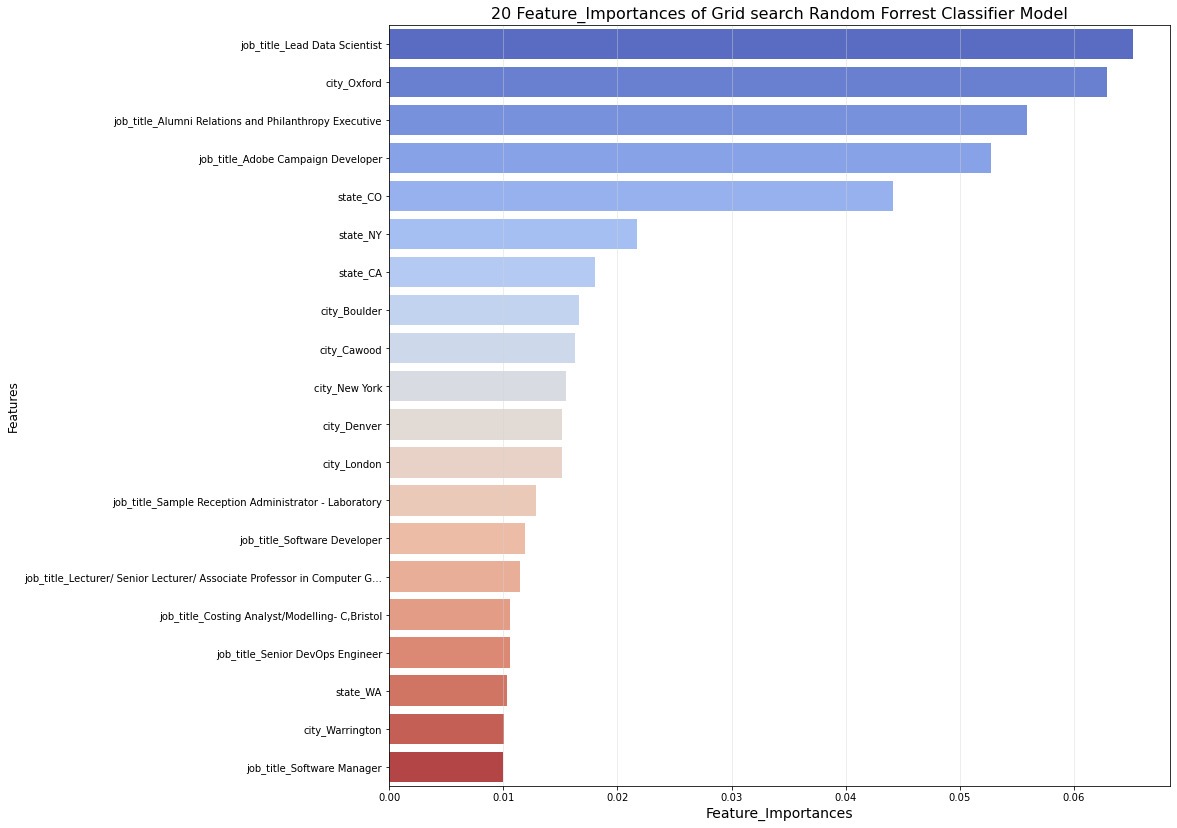

In [1909]:
fig,ax= plt.subplots(figsize=(14,14))

sns.barplot(data = rfgs_coef_df.sort_values(by='Feature_Importances',ascending=False).head(20), x='Feature_Importances', y ='Features', palette='coolwarm')
plt.title('20 Feature_Importances of Grid search Random Forrest Classifier Model', fontsize=16)
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

ax.set_xlabel('Feature_Importances', fontsize=14)
ax.set_ylabel('Features', fontsize=12)
plt.show()

In [1910]:
# Best Grid seach Score of Random Forrest Classifier model of the test set
best_rfgs.score(X_test,y_test)

0.9028776978417267

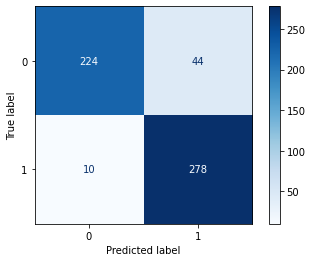

In [1911]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predicting salaries in X_test given predictors developed with X_train
y_probs = best_rfgs.predict(X_test)  

# plot confusion matrix TEST set
plot_confusion_matrix(best_rfgs, X_test, y_test, cmap='Blues')

# print(confusion_matrix(y_test, y_probs))

In [1912]:
#Create classification report test data
print(classification_report(y_test, y_probs))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       268
           1       0.86      0.97      0.91       288

    accuracy                           0.90       556
   macro avg       0.91      0.90      0.90       556
weighted avg       0.91      0.90      0.90       556



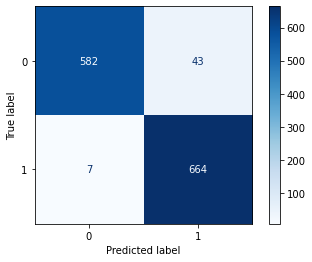

In [1913]:
# plot confusion matrix TRAIN set

y_probstr = best_rfgs.predict(X_train)  
plot_confusion_matrix(best_rfgs, X_train, y_train, cmap='Blues')

In [1914]:
#Create classification report Train data

print(classification_report(y_train, y_probstr))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       625
           1       0.94      0.99      0.96       671

    accuracy                           0.96      1296
   macro avg       0.96      0.96      0.96      1296
weighted avg       0.96      0.96      0.96      1296



Text(0.5, 1.0, 'ROC Curves of Test set')

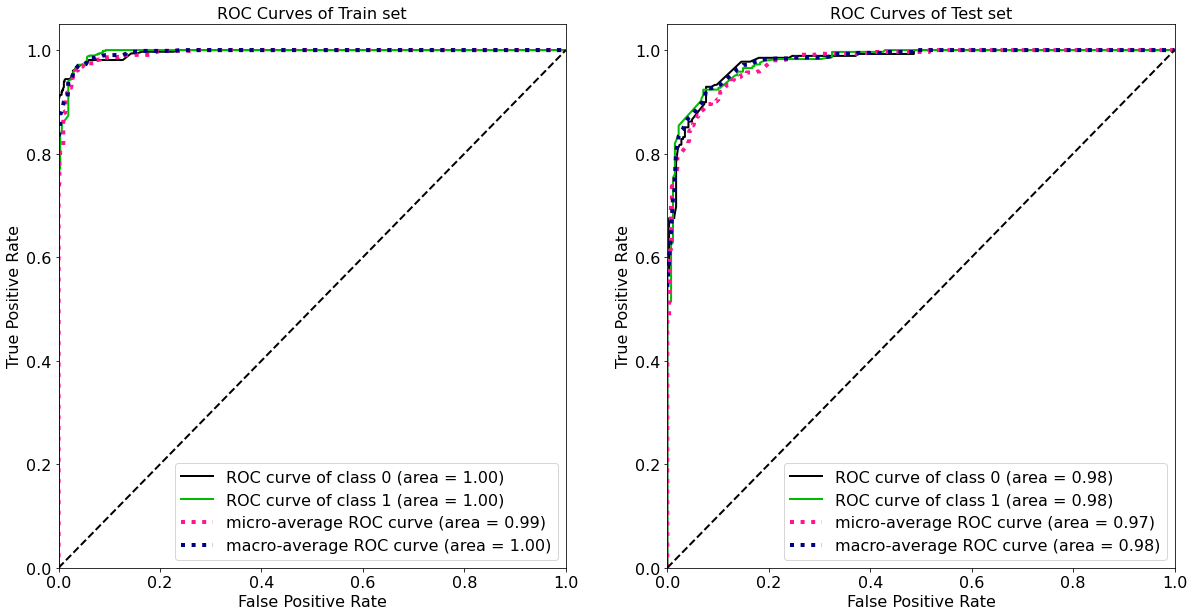

In [1924]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap


# Plot the ROC curves of Train and Test data

probs1 = best_rfgs.predict_proba(X_train)
probs2 = best_rfgs.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
skplt.metrics.plot_roc(y_train, probs1, plot_micro=True, plot_macro=True, title_fontsize= 20, 
                       text_fontsize=16, figsize=(12 ,10), ax = ax1)
skplt.metrics.plot_roc(y_test, probs2, plot_micro=True, plot_macro=True, title_fontsize= 20, 
                       text_fontsize=16, figsize=(12 ,10), ax = ax2
                      )
ax1.set_title('ROC Curves of Train set', fontsize = 16)
ax2.set_title('ROC Curves of Test set', fontsize = 16)

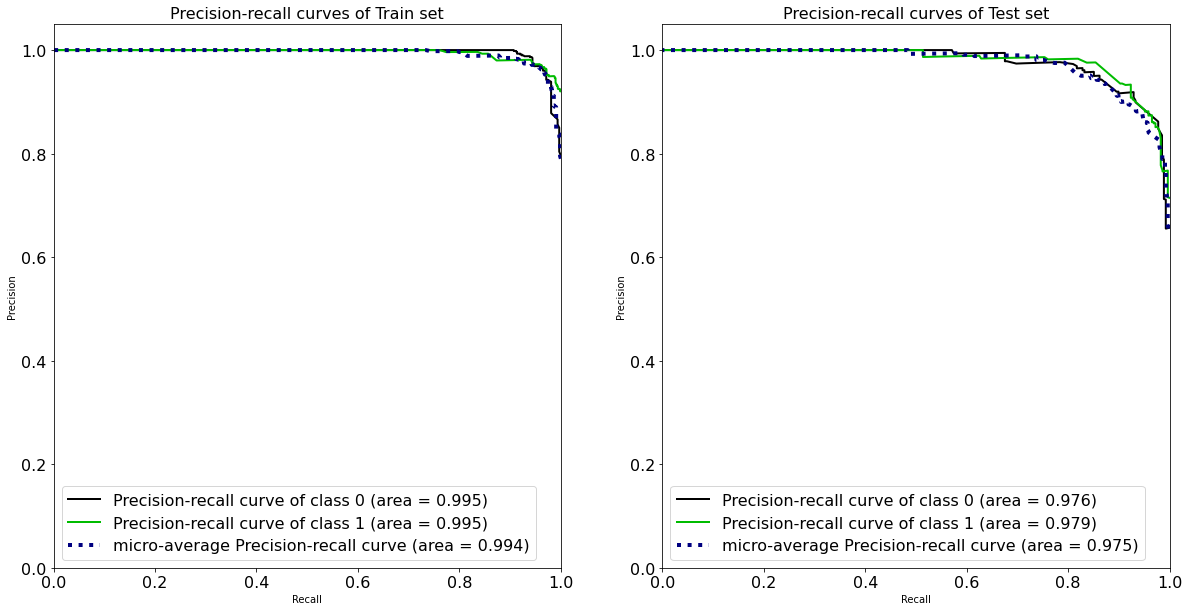

In [1926]:
# Plot the precision-recall curves

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(20,10))
skplt.metrics.plot_precision_recall(y_train, probs1, 
                       plot_micro=True, title_fontsize=20, text_fontsize=16, ax=ax1)
skplt.metrics.plot_precision_recall(y_test, probs2, plot_micro = True,
                                   title_fontsize=20, text_fontsize=16, ax=ax2)

ax1.set_title('Precision-recall curves of Train set', fontsize = 16)
ax2.set_title('Precision-recall curves of Test set', fontsize = 16)
plt.show()


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

# Precision/recall /curves

The tradeoff between detecting high salary vs low salary positions is preferencing in higher precision or recall or have a balance between the two. In the best predicting model (Random Forrest with grid search) low class has high precision score (0.99) which means it has only a few incorectly predicted (false positives) points as low class while it wasnt low class salary. Low class classification report also shows more lower recall score - 0.93 , which means it has more false negatives by predicting low class as high class salary .
High class has opposite predictions , it has more false positives (precision score 0.94) and just few false negatives (recall score 0.99). 

If we want to achive class prediction with high recall , we will eliminate all wrong predictions of the class we are looking for (in this case high salary class) and have more false positives , we will end up having more data points classified as the high class . While high precision will eliminate false positives (high class predicted as low class) but recall score will go lower and we would end up predicting low class as high class. 
We can also add from the ROC curves that the higher accuracy of True positives the more false positives count will slightly increase .

In [1954]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy import sparse
from sklearn.pipeline import make_pipeline

# X_tr = indeed[['job_title', 'state', 'city', 'summary']]
# tfid = TfidfVectorizer(stop_words='english',max_features=20000,norm='l2')
# # one_hot = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

# col_trans = ColumnTransformer([('text', tfid, 'summary') 
# #                                ('categories', one_hot, ['city', 'state']),
#                               ]) 
# # , remainder='passthrough', sparse_threshold=0.3

# pipe = make_pipeline(col_trans, LogisticRegression(C = 1.0, l1_ratio = 0.001, penalty= 'elasticnet', solver= 'saga'))
# pipe.fit(X_tr, y_tr)

# print('Train score', pipe.score(X_tr, y_tr))
# print('Mean CV score', cross_val_score(pipe, X_tr, y_tr, cv=kf).mean())

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
X_tr = indeed['summary']
y_tr = indeed['high']


tfid = TfidfVectorizer(stop_words='english',
                                      max_features=20000,
                                      norm='l2')

tfid.fit(X_tr)

train = pd.DataFrame(tfid.transform(X_tr).toarray(), columns = tfid.get_feature_names())
model = LogisticRegression(C = 1.0, l1_ratio = 0.001, penalty= 'elasticnet', solver= 'saga')


model.fit(train, y_tr)
y_pred = model.predict(train)
print('Train score', model.score(train, y_tr))
print('Mean CV score', cross_val_score(model, train, y_tr, cv=kf).mean())

Train score 0.9622030237580994
Mean CV score 0.8979310847235376


In [1965]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(stop_words='english')
cvec.fit(X_tr)


df = pd.DataFrame(cvec.transform(X_tr).toarray(),
                  columns=cvec.get_feature_names())

df.sum(axis=0).transpose().sort_values(0, ascending=False)[:15]

data          1344
experience     784
learning       623
machine        508
skills         257
working        189
high           177
science        174
pipelines      173
team           165
knowledge      162
analysis       161
using          160
management     158
design         154
dtype: int64

In [1964]:
df[y_tr == 0].sum(axis=0).sort_values(0, ascending=False)[:10]

data          537
learning      331
machine       260
experience    246
best          140
practice      125
knowledge     119
management    105
analysis      102
insights      100
dtype: int64

In [1963]:
df[y_tr == 1].sum(axis=0).sort_values(0, ascending=False)[:10]

data          807
experience    538
learning      292
machine       248
skills        163
pipelines     161
design        148
analytics     134
models        119
automation    115
dtype: int64

Text(0.5, 1.0, 'Precision recall curves of Train set')

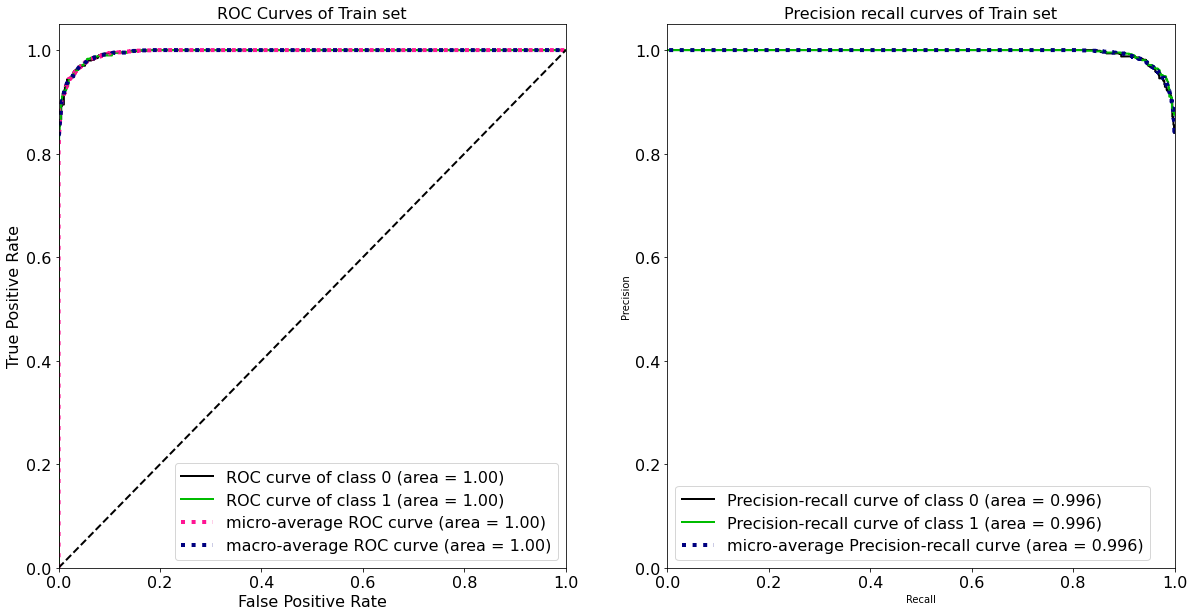

In [1956]:
# Plot the ROC curves Precision recall curves of Train set , using Tfidf Vectorizer with grid searched LR model.

probss1 = model.predict_proba(train)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

skplt.metrics.plot_roc(y_tr, probss1, plot_micro=True, plot_macro=True, title_fontsize= 20, 
                       text_fontsize=16, figsize=(12 ,10), ax = ax1)

skplt.metrics.plot_precision_recall(y_tr, probss1, 
                       plot_micro=True, title_fontsize=20, text_fontsize=16, ax=ax2)

ax1.set_title('ROC Curves of Train set', fontsize = 16)
ax2.set_title('Precision recall curves of Train set', fontsize = 16)

In [ ]:
#  Had some issue to do multi predictors, it was throwing me an error, could not figure out what I am doing wrong.

The new model with Tf-idf Vectotizer performed good as well, I used only summary column as predictor of salary class and obtained Mean CV score on train set of 0.8979. The precision recall curves and ROC curves performed with very high accuracy scores. 








### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

## Summary

Gathering results by webscaping , it gave me a lot of duplicates, lots of NaN values in Salary column and some in Location column. Eventually after droping all NaN values in Salary column and duplicates in Location column, I got the final dataset. Originally I webscrapped DS, ML jobs from USA , then I decided to add UK cities to see what will prevail more on predicting High vs Low salary class. Before I build any model , I extracted into new column city names , one more column of state names (for data points that it was relevant), for further differentiation of what city and state can predict better salary class. Also I converted US dollars salaries into pound currency to have equal value of salary in one currency. 

I ran first prediction of salary class with one predictor of City locations and got good Mean CV score on training data of 0.68 and 0.67 at Logistic Regression and KNN models respectively. The median salary in my dataset is £55000. I noticed that many US cities are tend to be a good predictors at defining High salary class and many UK cities tend to predict more the Low salary class. 
Using more predictors for my models I obtained 0.9027 mean CV train score on Logistic Regression model and 0.80 mean CV train score on Random Forest model. After using Grid Search to find the optimal parameters for both models, the best scores achieved on my training and testing data for the Logistic Regression model was an accuracy of 0.9027 and  0.9262 respectively, while the best scores for my optimised Random Forrest model were 0.9043 on training and 0.9028 on testing data. Taking into account baseline of 0.51 at predicting salary class, grid search models are doing pretty good with very high accuracy scores. Across different models , we can point out the Lead Data Scientist position as most well paid job. It has highest coefficient at Logistic Regression model along with highest feature importance of Random Forrest model .

As the graphs above show, the Logistic Regression Model coefficients indicate that the job titles with words Graduate,  Junior, title Alumni Relations Executive are predictors of a low salary, while Lead and Senior are indicators of a high salary. The Random Forest and it's Feature Importances metric tends to agree that these are key indicators in a decision tree.

In regards to the exercise of incorrectly classifying a job as low salary as opposed to high salary, this is a question of minimising false positives in the prediction. The tradeoff for this task is illustrated in the ROC curve for each model, which gives a visualisation of the increased number of false positives for each increase in true positives that my models predict but overall the last models did very good job with accuracies of aroung 90% and above.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

# Little conclusion

Now that I had a relatively accurate predictive model, I used it to see how common job titles stacked up against each other in terms of pay. The results were not too surprising, but good to know nonetheless. Lead Data scientists, Adobe Campaign Developer, Senior DevOps Engineer, Lead Machine Learning DS are well paid all across the UK and USA. 

On the other hand, any job with title Junior/ Graduate were paid poorly across the board. Jobs with title Alumni Relations and Philanthropy Executive also tend to be low paid salary, which is reasonable because it can be related to charity and some internships. 

Colorado state was the best location in terms of pay for data science and machine learning related jobs. Some other good locations for data science were California, New York NY, Miami FL. 

Salaries across USA are more well paid rather than across UK cities .